In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd

from utility import get_all_files_paths
from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch

In [2]:
dataset_path="data/spec/GTZAN_646"
model_save_path="models/Echoes"
csv_save_path="output/Echoes_output"
encoded_space_dim=128

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

In [3]:
class AudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        data = data[np.newaxis, :, :]  # Add a channel dimension
        data = torch.tensor(data, dtype=torch.float32)
        
        # Extract label from file name
        filename = os.path.basename(file_path)
        label_str = filename.split('.')[0]
        label = self.label_to_index(label_str)
        
        return data, label

    @staticmethod
    def label_to_index(label_str):
        label_map = {'blues': 'blues', 'disco': 'disco', 'rock': 'rock', 'metal': 'metal', 'classical': 'classical', 'pop': 'pop', 'reggae':'reggae','country':'country', 'hiphop':'hiphop', 'jazz':'jazz'}  # Extend this as needed
        return label_map.get(label_str, -1)  # Return -1 if label is not found

genres = ['blues', 'disco', 'rock', 'metal', 'pop', 'classical', 'reggae', 'country','hiphop','jazz']

genre_file_paths = {genre: get_all_files_paths(f"{dataset_path}/{genre}", [".npy"]) for genre in genres}

train_file_paths = []
valid_file_paths = []
test_file_paths = []

for genre, paths in genre_file_paths.items():
    m = len(paths)
    test_size = int(m * 0.2)
    valid_size = int((m - test_size) * 0.1)
    train_size = m - test_size - valid_size
    
    paths = np.array(paths)
    np.random.shuffle(paths)
    
    train_paths = paths[:train_size]
    valid_paths = paths[train_size:train_size + valid_size]
    test_paths = paths[train_size + valid_size:]
    
    train_file_paths.extend(train_paths)
    valid_file_paths.extend(valid_paths)
    test_file_paths.extend(test_paths)

train_dataset = AudioDataset(train_file_paths)
valid_dataset = AudioDataset(valid_file_paths)
test_dataset = AudioDataset(test_file_paths)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 720
Validation set size: 80
Test set size: 200


In [4]:
### Define an optimizer (both for the encoder and the decoder)
lr= 0.0001
### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.05, inplace=True)
    (2): Linear(in_features=512, out_features=167936, bias=True)
    (3): LeakyReLU(negative_slope=0.05, inplace=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 16, 41))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.05, inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), ou

In [5]:
total_epochs = 100
beta = 1

diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(total_epochs):

	# beta = epoch / total_epochs  # Increase beta over time

	train_loss =train_epoch(encoder, decoder, device, train_loader, optim, beta)
	val_loss = test_epoch(encoder,decoder,device,test_loader, beta)
	print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, total_epochs, train_loss,val_loss))
	diz_loss['train_loss'].append(train_loss)
	diz_loss['val_loss'].append(val_loss)

	if (epoch+1)%10 ==0: 
		torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
		torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	# plot_ae_outputs(encoder,decoder,n=10)


 EPOCH 1/100 	 train loss 29866.28515625 	 val loss 8986.853515625

 EPOCH 2/100 	 train loss 12972.326171875 	 val loss 9310.8583984375


KeyboardInterrupt: 

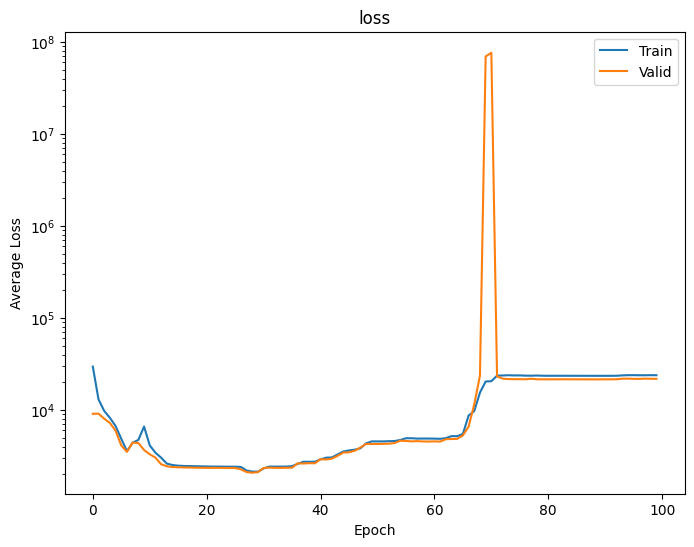

In [6]:
import matplotlib.pyplot as plt
# Plot losses
plt.figure(figsize=(8,6))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [9]:
encoder_path=f"{model_save_path}/encoder_30.pth"
decoder_path=f"{model_save_path}/decoder_30.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

encoder=load_encoder(encoder_path, encoded_space_dim)
# decoder=load_decoder(decoder_path, 64)
# encoder.to(device)

/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.devic

In [10]:
from tqdm import tqdm
from encoder import encode_data

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].to(device)
    label = sample[1]
    
    # Encode image
    # encoder.eval()
    # with torch.no_grad():
    #     encoded_img  = encoder(img)
    # Append to list
    # encoded_img = encoded_img.flatten().cpu().numpy()
    
    # print(img.shape)
    
    encoded_img = encode_data(encoder, img)
    
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/gtzan_encoded.csv", index=False)
encoded_samples

  0%|          | 0/200 [00:00<?, ?it/s]/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram_tensor = torch.tensor(spectrogram, dtype=torch.float32).to(device)
100%|██████████| 200/200 [00:00<00:00, 515.35it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,Enc. Variable 126,Enc. Variable 127,label
0,0.978242,0.469122,0.277542,-0.242107,-0.119624,-0.172106,0.135950,0.030622,-0.239917,0.491075,...,0.345982,-0.105791,0.140475,-0.827465,-0.331032,1.875493,0.490937,-0.384413,0.148363,blues
1,1.381428,-0.853384,0.007183,0.255923,-0.333690,0.271300,0.950984,-0.154470,-0.154454,0.525370,...,0.177269,-0.051920,-0.019832,-0.725146,0.688807,-1.639932,-0.210953,0.515503,0.350756,blues
2,-0.309658,-0.677820,0.174011,0.162128,-0.135488,0.069096,-0.831562,-0.332480,-0.167293,0.114172,...,0.401370,0.041299,-0.084865,-2.316530,-1.083784,2.025445,-1.244818,1.954396,0.493120,blues
3,1.535950,1.124148,0.198189,0.075092,-0.047779,-0.104632,-1.869299,-0.051762,-0.286399,0.313845,...,0.254847,0.023364,0.175140,1.096558,-1.108585,-0.554222,-0.447978,0.092202,0.160021,blues
4,0.761862,1.061542,-0.047806,0.237488,-0.193462,0.061559,0.209060,-0.178465,-0.035270,0.152096,...,-0.045076,0.032580,-0.219366,0.700959,-1.169963,-0.790093,1.226777,1.388385,0.157870,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.713554,-1.283013,0.397828,-0.165781,-0.417879,0.666877,-1.302995,0.144840,-0.142545,0.448783,...,0.646015,0.041430,-0.154843,0.378051,0.556011,0.108559,0.282702,2.426284,0.487775,jazz
196,0.681092,0.570367,-0.032003,0.390317,-0.526843,0.096264,-0.486460,-0.172776,-0.031185,0.023704,...,0.684313,-0.038136,0.148277,1.310877,-0.439341,-0.472976,-0.012955,-0.732789,0.025921,jazz
197,-0.043148,2.075701,-0.044008,-0.254594,0.102818,-0.110712,-0.272544,-0.125327,-0.106585,0.108152,...,0.130098,0.194015,0.003668,0.665890,1.307025,-1.172170,-0.909321,-0.020654,0.484009,jazz
198,-0.803580,0.853420,0.030228,0.099758,-0.060817,-0.043506,-1.260751,0.213150,-0.104548,0.262284,...,0.345939,0.332886,-0.189933,1.431075,0.830998,0.790206,-0.954843,-1.785169,0.263111,jazz
